In [1]:
from google.colab import drive
import os
import shutil
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
#Mount Google Drive
drive.mount('/content/drive')

#Load data
csv_path = '/content/drive/MyDrive/MLProjects/pneumonia-detection/metadata/Data_Entry_2017.csv'
df = pd.read_csv(csv_path)
df.head()

Mounted at /content/drive


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [3]:
#Label as 1 if 'Pneumonia' is in the list, else 0 if 'No Finding'
df_binary = df.copy()
df_binary['label'] = df_binary['Finding Labels'].apply(
    lambda x: 1 if 'Pneumonia' in x else (0 if x == 'No Finding' else None)
)

#Drop irrelevant rows
df_binary = df_binary.dropna(subset=['label'])
df_binary['label'] = df_binary['label'].astype(int)

#Keep only useful columns
df_binary = df_binary[['Image Index', 'label']]
df_binary.head()

,Image Index,label
3,00000002_000.png,0
13,00000005_000.png,0
14,00000005_001.png,0
15,00000005_002.png,0
16,00000005_003.png,0


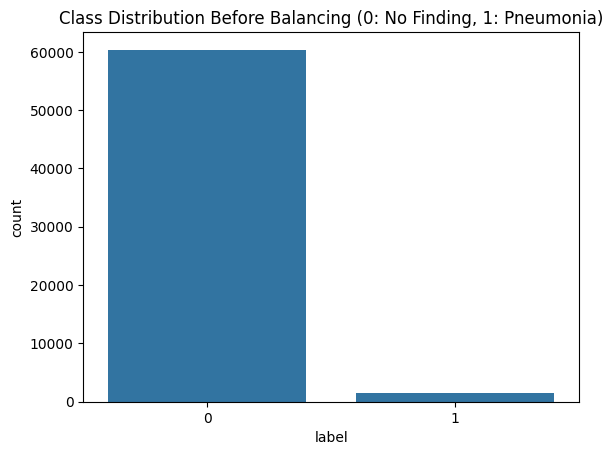

In [4]:
sns.countplot(data=df_binary, x='label')
plt.title("Class Distribution Before Balancing (0: No Finding, 1: Pneumonia)")
plt.show()

In [5]:
#Sample 1431 from each class
df_pneumonia = df_binary[df_binary['label'] == 1].sample(n=1431, random_state=42)
df_no_finding = df_binary[df_binary['label'] == 0].sample(n=1431, random_state=42)

#Combine and shuffle
df_balanced = pd.concat([df_pneumonia, df_no_finding]).sample(frac=1, random_state=42).reset_index(drop=True)

#Show final balance
df_balanced['label'].value_counts()


,count
label,
0,1431
1,1431


In [6]:
#Check missing/duplicated data
print('Missing Values:\n', df_binary.isnull().sum())
print('Duplicates:\n', df_binary.duplicated().sum())

Missing Values:
 Image Index    0
label          0
dtype: int64
Duplicates:
 0


In [15]:
#Source folder
base_path = '/content/drive/MyDrive/MLProjects/pneumonia-detection/data/pneumonia_original'

#Target folder
target_dir = '/content/drive/MyDrive/MLProjects/pneumonia-detection/data/pneumonia_single'
os.makedirs(target_dir, exist_ok=True)

#Go through each images_#/images/ folder and copy .png files
for folder in os.listdir(base_path):
    if folder.startswith('images_'):
        nested_image_dir = os.path.join(base_path, folder, 'images')
        if os.path.exists(nested_image_dir):
            for file in os.listdir(nested_image_dir):
                src = os.path.join(nested_image_dir, file)
                dst = os.path.join(target_dir, file)
                if not os.path.exists(dst):
                    shutil.copy(src, dst)

print("Merged all images into:", target_dir)

Merged all images into: /content/drive/MyDrive/MLProjects/pneumonia-detection/data/pneumonia_single


In [11]:
#Contains columns: 'Image Index', 'label'
df_balanced.shape  # (2862, 2)

#Paths
full_image_dir = '/content/drive/MyDrive/MLProjects/pneumonia-detection/data/pneumonia_single'
subset_dir = '/content/drive/MyDrive/MLProjects/pneumonia-detection/data/pneumonia_subset'
os.makedirs(subset_dir, exist_ok=True)

#Copy only the 2,862 images
missing = []
for fname in df_balanced['Image Index']:
    src = os.path.join(full_image_dir, fname)
    dst = os.path.join(subset_dir, fname)
    if os.path.exists(src):
        shutil.copy(src, dst)
    else:
        missing.append(fname)

print(f" Copied {len(df_balanced) - len(missing)} images to {subset_dir}")
print(f" Missing {len(missing)} images (check names or upload)")

 Copied 2862 images to /content/drive/MyDrive/MLProjects/pneumonia-detection/data/pneumonia_subset
 Missing 0 images (check names or upload)


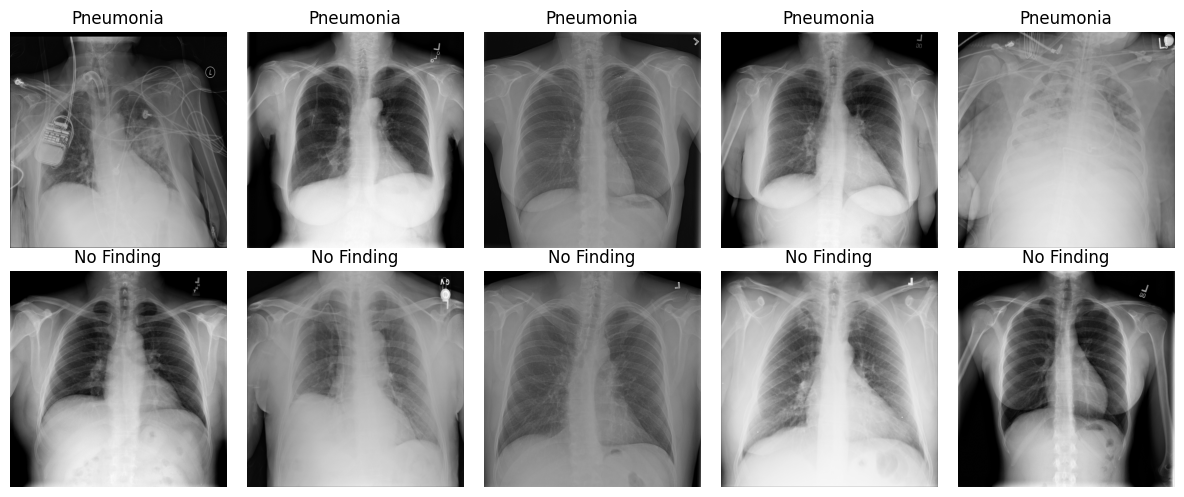

In [17]:
image_dir = '/content/drive/MyDrive/MLProjects/pneumonia-detection/data/pneumonia_subset'

#Plot a few 'pneumonia' and 'no finding' images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, label in enumerate([1, 0]):
    sample = df_balanced[df_balanced['label'] == label].sample(5)
    for j, image_file in enumerate(sample['Image Index']):
        img = Image.open(os.path.join(image_dir, image_file))
        axes[i, j].imshow(img, cmap='gray')
        axes[i, j].axis('off')
        axes[i, j].set_title('Pneumonia' if label == 1 else 'No Finding')
plt.tight_layout()
plt.show()


In [13]:
#Save cleaned and balanced dataset
df_balanced.to_csv('balanced_labels.csv', index=False)

In [14]:
#70/15/15 split
train_split = int(0.7 * len(df_balanced))
val_split = int(0.85 * len(df_balanced))

df_train = df_balanced[:train_split]
df_val = df_balanced[train_split:val_split]
df_test = df_balanced[val_split:]

#Save splits
df_train.to_csv('train_labels.csv', index=False)
df_val.to_csv('val_labels.csv', index=False)
df_test.to_csv('test_labels.csv', index=False)

#Check splits
print("Train size:", len(df_train))
print("Validation size:", len(df_val))
print("Test size:", len(df_test))

Train size: 2003
Validation size: 429
Test size: 430
